In [1]:
!pip install -q datasets transformers scikit-learn shap umap-learn matplotlib optuna ray[tune] plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.9 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
import torch
import shap
import matplotlib.pyplot as plt
import umap
import plotly.express as px
import pandas as pd
from math import sqrt

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import StratifiedKFold

from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from torch.utils.data import DataLoader

import optuna  

In [3]:
SEED = 42
MODEL_NAME = "distilbert-base-uncased"
SPLIT_TRAIN_RATIO = 0.7
SPLIT_VAL_RATIO = 0.15  # leftover => test
CALIBRATION_BINS = 10

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
dataset = load_dataset("oishooo/formality_classification")
full_data = dataset["train"]  # single "train" split

data_list = []
for item in full_data:
    txt = str(item["text"]) if item["text"] else ""
    lbl = item["formality_label"]  # "formal","informal","neutral"
    data_list.append({"text": txt, "label_str": lbl})

random.shuffle(data_list)
n_total = len(data_list)
print(f"Total samples: {n_total}")

README.md:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


formality_dataset.csv:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2523 [00:00<?, ? examples/s]

Total samples: 2523


In [5]:
train_size = int(SPLIT_TRAIN_RATIO * n_total)
val_size   = int(SPLIT_VAL_RATIO * n_total)
test_size  = n_total - train_size - val_size

train_data_list = data_list[:train_size]
val_data_list   = data_list[train_size : train_size + val_size]
test_data_list  = data_list[train_size + val_size : ]

print(f"Train: {len(train_data_list)}, Val: {len(val_data_list)}, Test: {len(test_data_list)}")


Train: 1766, Val: 378, Test: 379


In [6]:

label2id = {"formal": 0, "informal": 1, "neutral": 2}
id2label = {0: "formal", 1: "informal", 2: "neutral"}

def encode_label(lbl_str):
    return label2id[lbl_str]

In [7]:
def plot_class_distribution_interactive(train_data, val_data, test_data):
    # Count each label in train, val, test
    unique_labels = ["formal","informal","neutral"]

    def label_counts(data_list):
        return [sum(1 for x in data_list if x["label_str"]==lbl) for lbl in unique_labels]

    train_counts = label_counts(train_data)
    val_counts   = label_counts(val_data)
    test_counts  = label_counts(test_data)

    # We'll create a DataFrame for Plotly
    df_dist = pd.DataFrame({
        "Label": unique_labels*3,
        "Count": train_counts + val_counts + test_counts,
        "Set"  : ["Train"]*3 + ["Val"]*3 + ["Test"]*3
    })

    fig = px.bar(
        df_dist,
        x="Label",
        y="Count",
        color="Set",
        barmode="group",
        title="Interactive Class Distribution"
    )
    fig.show()

plot_class_distribution_interactive(train_data_list, val_data_list, test_data_list)


In [8]:
def build_dataset(dlist, tokenizer):
    ds = Dataset.from_list(dlist)
    def tokenize_map(ex):
        enc = tokenizer(ex["text"], padding="max_length", truncation=True, max_length=128)
        enc["label"] = encode_label(ex["label_str"])
        return enc
    ds = ds.map(tokenize_map, batched=False)
    ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])
    return ds

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset = build_dataset(train_data_list, tokenizer)
val_dataset   = build_dataset(val_data_list, tokenizer)
test_dataset  = build_dataset(test_data_list, tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1766 [00:00<?, ? examples/s]

Map:   0%|          | 0/378 [00:00<?, ? examples/s]

Map:   0%|          | 0/379 [00:00<?, ? examples/s]

In [9]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

In [10]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    )

In [11]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./formality-clf-output",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def hp_space_optuna(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_categorical("num_train_epochs", [2,3,4]),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.2),
        "weight_decay": trial.suggest_float("weight_decay", 1e-3, 1e-1, log=True),
    }

print("\n=== Starting hyperparameter search with optuna... ===")
search_result = trainer.hyperparameter_search(
    backend="optuna",
    direction="minimize",
    hp_space=hp_space_optuna,
    n_trials=8,
    compute_objective=lambda metrics: metrics["eval_loss"]
)
print("Best hyperparams found (optuna):", search_result.hyperparameters)

best_hp = search_result.hyperparameters


[I 2025-04-07 17:16:59,978] A new study created in memory with name: no-name-09f49280-aa13-4b5f-b80f-4f76a84093dc
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Starting hyperparameter search with optuna... ===


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.343800,0.380686,0.873016,0.870310,0.873016,0.869933
2,0.262100,0.337214,0.875661,0.874211,0.875661,0.874638
3,0.089900,0.357767,0.880952,0.878536,0.880952,0.878755


[I 2025-04-07 17:17:54,753] Trial 0 finished with value: 0.357767254114151 and parameters: {'learning_rate': 1.0532730964519545e-05, 'num_train_epochs': 3, 'warmup_ratio': 0.05098467069851993, 'weight_decay': 0.034449783203448034}. Best is trial 0 with value: 0.357767254114151.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.337700,0.353734,0.878307,0.875995,0.878307,0.874433
2,0.212300,0.372121,0.883598,0.882398,0.883598,0.882840


[I 2025-04-07 17:18:31,623] Trial 1 finished with value: 0.3721214234828949 and parameters: {'learning_rate': 3.868635396150263e-05, 'num_train_epochs': 2, 'warmup_ratio': 0.18428915357033798, 'weight_decay': 0.010453521273370165}. Best is trial 0 with value: 0.357767254114151.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.322500,0.338208,0.865079,0.861707,0.865079,0.862062
2,0.230000,0.380481,0.875661,0.879456,0.875661,0.876580
3,0.030100,0.397620,0.883598,0.882512,0.883598,0.882707


[I 2025-04-07 17:19:25,574] Trial 2 finished with value: 0.3976202607154846 and parameters: {'learning_rate': 1.925728818667967e-05, 'num_train_epochs': 3, 'warmup_ratio': 0.014932191479283109, 'weight_decay': 0.06401716698541522}. Best is trial 0 with value: 0.357767254114151.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.368700,0.367979,0.883598,0.882888,0.883598,0.878836
2,0.228400,0.405580,0.880952,0.888014,0.880952,0.882690
3,0.007300,0.409553,0.888889,0.887346,0.888889,0.887804


[I 2025-04-07 17:20:19,525] Trial 3 finished with value: 0.4095534086227417 and parameters: {'learning_rate': 3.520828673606375e-05, 'num_train_epochs': 3, 'warmup_ratio': 0.1219366449262087, 'weight_decay': 0.025077798415660605}. Best is trial 0 with value: 0.357767254114151.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.343300,0.344050,0.870370,0.867302,0.870370,0.867493
2,0.244400,0.398086,0.875661,0.881728,0.875661,0.877065
3,0.022400,0.405921,0.880952,0.879503,0.880952,0.879855


[I 2025-04-07 17:21:13,630] Trial 4 finished with value: 0.40592101216316223 and parameters: {'learning_rate': 2.133530817973758e-05, 'num_train_epochs': 3, 'warmup_ratio': 0.006795237364487461, 'weight_decay': 0.0019238986890525518}. Best is trial 0 with value: 0.357767254114151.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.322300,0.341360,0.867725,0.864608,0.867725,0.864997
2,0.231600,0.352580,0.873016,0.874009,0.873016,0.873168
3,0.060000,0.376087,0.878307,0.875758,0.878307,0.876184


[I 2025-04-07 17:22:08,131] Trial 5 finished with value: 0.37608733773231506 and parameters: {'learning_rate': 1.518782323105411e-05, 'num_train_epochs': 3, 'warmup_ratio': 0.0014705167619934124, 'weight_decay': 0.016983657637810776}. Best is trial 0 with value: 0.357767254114151.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.340600,0.380288,0.865079,0.861723,0.865079,0.861507


[I 2025-04-07 17:22:24,217] Trial 6 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.336300,0.369313,0.859788,0.855850,0.859788,0.855564


[I 2025-04-07 17:22:40,341] Trial 7 pruned. 


Best hyperparams found (optuna): {'learning_rate': 1.0532730964519545e-05, 'num_train_epochs': 3, 'warmup_ratio': 0.05098467069851993, 'weight_decay': 0.034449783203448034}


In [13]:
best_training_args = TrainingArguments(
    output_dir="./formality-clf-output-best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    num_train_epochs=int(best_hp["num_train_epochs"]),
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=best_hp["learning_rate"],
    warmup_ratio=best_hp["warmup_ratio"],
    weight_decay=best_hp["weight_decay"],
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

best_trainer = Trainer(
    model_init=model_init,
    args=best_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("\n=== Training final model with best hyperparams... ===")
best_trainer.train()

test_results = best_trainer.evaluate(test_dataset)
print("\nFinal test set results with best hyperparams:", test_results)

logits = best_trainer.predict(test_dataset).predictions
labels_true = best_trainer.predict(test_dataset).label_ids
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
pred_classes = np.argmax(probs, axis=1)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Training final model with best hyperparams... ===


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.343800,0.380686,0.873016,0.870310,0.873016,0.869933
2,0.262100,0.337214,0.875661,0.874211,0.875661,0.874638
3,0.089900,0.357767,0.880952,0.878536,0.880952,0.878755



Final test set results with best hyperparams: {'eval_loss': 0.2923002541065216, 'eval_accuracy': 0.8812664907651715, 'eval_precision': 0.8828535060093083, 'eval_recall': 0.8812664907651715, 'eval_f1': 0.8812114542894972, 'eval_runtime': 0.9462, 'eval_samples_per_second': 400.546, 'eval_steps_per_second': 50.729, 'epoch': 3.0}


In [14]:
cm = confusion_matrix(labels_true, pred_classes)
print("\nPlain Confusion Matrix:\n", cm)

labels_ordered = ["formal","informal","neutral"]
df_cm = pd.DataFrame(cm, index=labels_ordered, columns=labels_ordered)

fig_cm = px.imshow(
    df_cm,
    text_auto=True,
    aspect="auto",
    title="Interactive Confusion Matrix",
    labels=dict(x="Predicted", y="True", color="Count")
)
fig_cm.update_xaxes(side="bottom")
fig_cm.show()



Plain Confusion Matrix:
 [[131   0   4]
 [  0 112  21]
 [ 10  10  91]]


In [15]:
def train_and_eval_kfold(data_list, k=3):
    all_labels = [encode_label(x["label_str"]) for x in data_list]
    indices = np.arange(len(data_list))
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

    fold_accuracies, fold_f1s = [], []

    for fold_idx, (tr_idx, vl_idx) in enumerate(skf.split(indices, all_labels)):
        print(f"\n=== K-Fold Fold {fold_idx+1}/{k} ===")

        tr_list = [data_list[i] for i in tr_idx]
        vl_list = [data_list[i] for i in vl_idx]

        ds_tr = build_dataset(tr_list, tokenizer)
        ds_vl = build_dataset(vl_list, tokenizer)

        # We'll re-use the best HP but disable saving for cross-validation
        fold_args = TrainingArguments(
            output_dir=f"./fold_{fold_idx+1}_output",
            eval_strategy="epoch",
            save_strategy="no",
            logging_strategy="steps",
            logging_steps=10,
            num_train_epochs=int(best_hp["num_train_epochs"]),
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            learning_rate=best_hp["learning_rate"],
            warmup_ratio=best_hp["warmup_ratio"],
            weight_decay=best_hp["weight_decay"],
            fp16=torch.cuda.is_available(),
            load_best_model_at_end=False,  # Must be false if no saving
            metric_for_best_model="eval_loss",
            report_to="none"
        )

        fold_trainer = Trainer(
            model_init=model_init,
            args=fold_args,
            train_dataset=ds_tr,
            eval_dataset=ds_vl,
            compute_metrics=compute_metrics
        )

        fold_trainer.train()
        results = fold_trainer.evaluate(ds_vl)
        fold_accuracies.append(results["eval_accuracy"])
        fold_f1s.append(results["eval_f1"])
        print(f"Fold {fold_idx+1} => Accuracy: {results['eval_accuracy']:.4f}, F1: {results['eval_f1']:.4f}")

    print("\n=== Cross-Validation Summary ===")
    print(f"Accuracy: mean={np.mean(fold_accuracies):.4f}, std={np.std(fold_accuracies):.4f}")
    print(f"F1      : mean={np.mean(fold_f1s):.4f}, std={np.std(fold_f1s):.4f}")

print("\n=== OPTIONAL: K-Fold Cross Validation with best hyperparams ===")
train_and_eval_kfold(data_list, k=3)


=== OPTIONAL: K-Fold Cross Validation with best hyperparams ===

=== K-Fold Fold 1/3 ===


Map:   0%|          | 0/1682 [00:00<?, ? examples/s]

Map:   0%|          | 0/841 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.306300,0.350537,0.875149,0.871611,0.875149,0.869589
2,0.257800,0.297353,0.888228,0.888849,0.888228,0.887905
3,0.103100,0.301492,0.889417,0.890735,0.889417,0.889492


Fold 1 => Accuracy: 0.8894, F1: 0.8895

=== K-Fold Fold 2/3 ===


Map:   0%|          | 0/1682 [00:00<?, ? examples/s]

Map:   0%|          | 0/841 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.490200,0.356694,0.856124,0.857849,0.856124,0.843469
2,0.284700,0.267819,0.891795,0.890611,0.891795,0.891074
3,0.210800,0.283870,0.894174,0.896250,0.894174,0.894529


Fold 2 => Accuracy: 0.8942, F1: 0.8945

=== K-Fold Fold 3/3 ===


Map:   0%|          | 0/1682 [00:00<?, ? examples/s]

Map:   0%|          | 0/841 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.498700,0.356016,0.884661,0.884100,0.884661,0.884366
2,0.177900,0.300865,0.879905,0.881385,0.879905,0.879779
3,0.112000,0.294891,0.888228,0.886634,0.888228,0.887081


Fold 3 => Accuracy: 0.8882, F1: 0.8871

=== Cross-Validation Summary ===
Accuracy: mean=0.8906, std=0.0026
F1      : mean=0.8904, std=0.0031


In [16]:
pred_confidences = np.max(probs, axis=1)
frac_of_pos, mean_pred_val = calibration_curve(
    (pred_classes == labels_true).astype(int),
    pred_confidences,
    n_bins=CALIBRATION_BINS
)

df_calib = pd.DataFrame({
    "mean_pred": mean_pred_val,
    "frac_pos" : frac_of_pos
})

fig_calib = px.line(
    df_calib,
    x="mean_pred",
    y="frac_pos",
    markers=True,
    title="Interactive Reliability Diagram"
)
fig_calib.add_shape(
    type="line",
    x0=0, y0=0, x1=1, y1=1,
    line=dict(color="gray", dash="dash")
)
fig_calib.update_layout(
    xaxis_title="Predicted Probability",
    yaxis_title="True Probability"
)
fig_calib.show()

In [17]:
acc = accuracy_score(labels_true, pred_classes)
n_test = len(labels_true)
z = 1.96
center = (acc + (z**2)/(2*n_test)) / (1 + (z**2)/n_test)
margin = (z * np.sqrt((acc*(1-acc) + (z**2)/(4*n_test)) / n_test)) / (1 + (z**2)/n_test)
ci_lower = center - margin
ci_upper = center + margin
print(f"\nAccuracy: {acc:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")



Accuracy: 0.8813 (95% CI: [0.8448, 0.9101])


In [18]:
mis_idx = np.where(pred_classes != labels_true)[0]
print(f"\nNumber of misclassifications: {len(mis_idx)}")
random.shuffle(mis_idx)
for i in mis_idx[:5]:
    txt = test_data_list[i]["text"]
    print("\n--- Misclassification ---")
    print("Text:", txt)
    print("True Label:", id2label[labels_true[i]])
    print("Pred Label:", id2label[pred_classes[i]])


Number of misclassifications: 45

--- Misclassification ---
Text: I also prefer Marmite.
True Label: informal
Pred Label: neutral

--- Misclassification ---
Text: Because it's only a possession charge, I do not believe he could get in trouble. He would not be actively assisting him in hiding it, rather simply failing to report it. Now, if he put it in a hidden, encrypted file and told his friend, that's a different ballgame. There is no duty to report a crime, except in special cases 
True Label: informal
Pred Label: neutral

--- Misclassification ---
Text: Miss Summas thought she was making a point about how it doesn't help to have 10 free points if you scored a 30--which a number of the kids did---but what message are they trying to send us? "
True Label: neutral
Pred Label: informal

--- Misclassification ---
Text: Wild animals are fine.  Wild *pets* (see: feral cat) are often not, because they're no longer adapted or necessarily suited to the local ecology.   I grew up in a huntin

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



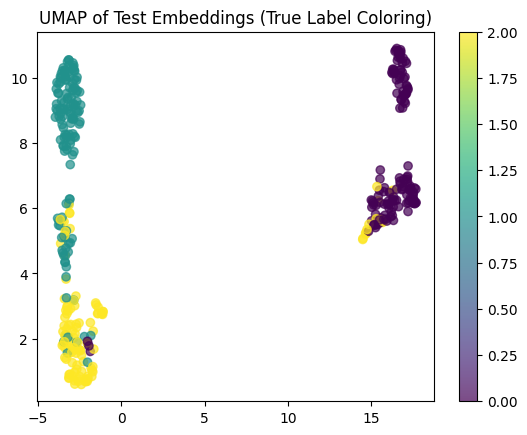

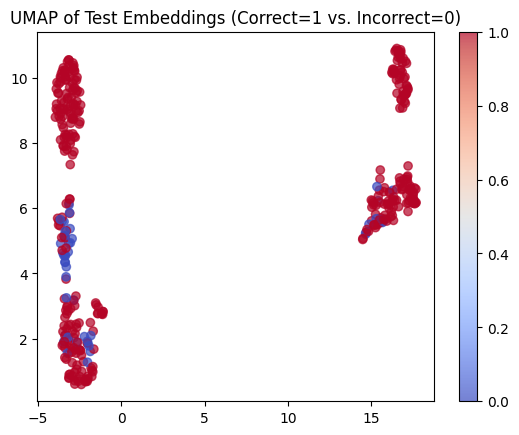

In [19]:
def get_embeddings(m, ds):
    loader = DataLoader(ds, batch_size=8, shuffle=False)
    m.eval()
    emb_list = []
    with torch.no_grad():
        for batch in loader:
            in_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            out = m.distilbert(in_ids, attention_mask=attn)
            cls_emb = out.last_hidden_state[:, 0, :]
            emb_list.append(cls_emb.cpu().numpy())
    return np.concatenate(emb_list, axis=0)

test_embs = get_embeddings(best_trainer.model, test_dataset)
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=SEED)
umap_2d = umap_reducer.fit_transform(test_embs)

plt.figure()
plt.scatter(umap_2d[:,0], umap_2d[:,1], c=labels_true, cmap='viridis', alpha=0.7)
plt.title("UMAP of Test Embeddings (True Label Coloring)")
plt.colorbar()
plt.show()

corr_mask = (pred_classes==labels_true).astype(int)
plt.figure()
plt.scatter(umap_2d[:,0], umap_2d[:,1], c=corr_mask, cmap='coolwarm', alpha=0.7)
plt.title("UMAP of Test Embeddings (Correct=1 vs. Incorrect=0)")
plt.colorbar()
plt.show()

In [20]:
print("\n=== SHAP with KernelExplainer (one text = one feature) ===")

def model_predict_for_shap(text_2d_array):
    texts = [str(row[0]) for row in text_2d_array]
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)
    with torch.no_grad():
        out = best_trainer.model(**inputs).logits
        probs_ = torch.softmax(out, dim=-1).cpu().numpy()
    return probs_

bg_samples = random.sample(train_data_list, 3)
bg_texts = np.array([x["text"] for x in bg_samples], dtype=object).reshape(-1,1)
explainer = shap.KernelExplainer(
    model_predict_for_shap,
    bg_texts,
    link="identity"
)

test_samples = random.sample(test_data_list, 3)
test_text_array = np.array([ts["text"] for ts in test_samples], dtype=object).reshape(-1,1)
shap_vals = explainer.shap_values(test_text_array, nsamples=50)

for i,ts in enumerate(test_samples):
    print(f"\nExample {i} => text: {repr(ts['text'])}")
    for cls_idx in range(3):
        shap_val = shap_vals[cls_idx][i][0]
        print(f"   Class {cls_idx} shap: {shap_val:.4f}")

print("\nNote: Single text is 1 'feature' => only 1 shap value per class.\n")




=== SHAP with KernelExplainer (one text = one feature) ===


  0%|          | 0/3 [00:00<?, ?it/s]


Example 0 => text: 'This kind of made my day, too!  I feel pathetic and lonely!'
   Class 0 shap: -0.3193
   Class 1 shap: 0.5795
   Class 2 shap: -0.2603

Example 1 => text: '< http://cityguide.news - press.com/fe/Auto/Search.asp >'
   Class 0 shap: -0.2752
   Class 1 shap: -0.3154
   Class 2 shap: 0.5906

Example 2 => text: 'HSV-1-induced cytopathic effects are clearly characterized following inoculation with virus from standard laboratory cultures and human infections.'
   Class 0 shap: 0.6564
   Class 1 shap: -0.3894
   Class 2 shap: -0.2670

Note: Single text is 1 'feature' => only 1 shap value per class.

